# Introduction

Deep learning models are an essential part of big data anlaysis within healthcare. Neutral networks are utilized to optimally predict future diagnosis, hospital readmission, drug interaction, treatment recommendation, etc. Specifically, graph neural networks (GNNs) are vital to drug discovery, molecular property prediction, and other drug interaction prediciton tasks; one example is drug pair scoring, the prediciton task of determining the relationship between a pair of drugs, based on the known effects of various other drug pairs. Some specific predictions between drugs include drug-drug interaction, synergy, and polypharmacy side effects.

While there are open-scource drug interaction libraries available, they often predict based on a single molecule and do not allow for drug synergy predictions, predicting if the combined effect of a pair of drugs is more effective than the additive effect of each drug separately. There is no multi-use, streamlined framwork that is easily accessible by machine learning researchers.

The paper introduces ChemicalX [1], a library of PyTorch implementations of 11 prominent deep-learning models that predict various drug-drug interactions. Aside from the drug pair scoring deep-learning model architectures, this library also provides data loaders, integrated benchmark datasets, training, and evaluation routines.

All ChemicalX models were trained and tested across multiple datasets to predict drug-drug interaction, synergy, and polypharmacy side effects; and all models were evaulated using AUPRC, AUROC, and F1 metrics. Finally, the authors address use cases of the library by oncologists, computational chemists, drug safety researchers, and various oher machine learning researchers.


Links:
- [GitHub repository](https://github.com/nilakrishnan/dlh_598_final_project)
- [Final Presentation Video](?)

# Scope of Reproducibility
DeepSynergy [2] and DeepDDS [3] are two of the models implemented by the ChemicalX library.

The specific hypothesis that will be tested in this report is that DeepSynergy will outperform DeepDDS when trained and tested using the DrugComb [4] dataset to predict drug synergy. Specifically, the DeepSynergy model implemented in this report will have a higher AUPRC, higher AUROC, and higher F1 score than the DeepDDS model from the ChemicalX library.


# Methodology



##  Environment
Please ensure that the notebook is connected to a runtime with Python3 (version 3.10) and a T4 GPU before proceeding.

First, all necessary dependencies are installed:

In [1]:
import os
import torch

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html

!pip install torchdrug

Looking in links: https://data.pyg.org/whl/torch-2.2.1+cu121.html
Looking in links: https://data.pyg.org/whl/torch-2.2.1+cu121.html


The **chemicalx** dependecy is installed so the model implemented in this report can be evaulated against the implementation from the ChemicalX library as well as the DeepDDS model implementation. The **torchdrug** dependency is installed to utilize the PackedGraph and Molecule data structures.

In [2]:
import csv
import io
import json
import time
import torchdrug
import urllib.request
import warnings

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torch.utils.data import Dataset, DataLoader
from torchdrug.data import PackedGraph, Molecule
from sklearn.metrics import average_precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
INFO:numexpr.utils:NumExpr defaulting to 2 threads.


03:31:19   NumExpr defaulting to 2 threads.


##  Data
The raw data is from ChemicalX's [GitHub](https://github.com/AstraZeneca/chemicalx/tree/main) repository, which was originally sourced from DrugCombDB [2], which contains data on known synergistic drug pairs that are effective at destroying certain cancer cell types. The raw data includes 3 datasets: *drug_set.json* , *context_set.json*, and *labeled_triples.csv*.

*drug_set.json* provides drug IDs, their respective simplified molecular-input line-entry system (SMILE), which is a line notation describing the structure of the molecular compound, and their features.

*context_set.json* provides contexts, which are specific IDs of cancer cell lines and their features. Cell lines are populations of isolated cells that are commonly used in cancer treatment research.

*labeled_triples.csv* includes two drug IDs, a context, and a boolean indicating if the pair of drugs are synergetic.

In [3]:
# ignore warnings from torchdrug.data.Molecule
warnings.filterwarnings('ignore')

Download the raw data files:

In [4]:
!gdown 1B4rFgBQrH-UgY3MYx48awHcWHMIODumI
!gdown 15fjupmoovZgCUad5I6lNcYURkdTqECvn
!gdown 1SCNCDmwgCI9ATtc_WbiDtrl6wZs3qcg1&usp

Downloading...
From: https://drive.google.com/uc?id=1B4rFgBQrH-UgY3MYx48awHcWHMIODumI
To: /content/drug_set.json
100% 11.8M/11.8M [00:00<00:00, 63.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=15fjupmoovZgCUad5I6lNcYURkdTqECvn
To: /content/context_set.json
100% 140k/140k [00:00<00:00, 11.0MB/s]
/bin/bash: line 1: usp: command not found
Downloading...
From: https://drive.google.com/uc?id=1SCNCDmwgCI9ATtc_WbiDtrl6wZs3qcg1
To: /content/labeled_triples.csv
100% 4.27M/4.27M [00:00<00:00, 38.2MB/s]


In [5]:
drug_set_path = '/content/drug_set.json'
context_set_path = '/content/context_set.json'
labeled_triples_path = '/content/labeled_triples.csv'

Load the raw data:

In [6]:
def load_raw_data(drug_set_path, context_set_path, labeled_triples_path):
  drug_set = None
  context_set = None

  with open(drug_set_path) as f:
    drug_set = json.load(f)

  with open(context_set_path) as f:
    context_set = json.load(f)

  drug_features = {k: torch.FloatTensor(v["features"]).view(1, -1) for k, v in drug_set.items()}
  context_features = {k: torch.FloatTensor(np.array(v).reshape(1, -1)) for k, v in context_set.items()}
  labeled_triples = pd.read_csv(labeled_triples_path, encoding="utf8", sep=",", dtype={"drug_1": str, "drug_2": str, "context": str, "label": float})

  return drug_features, context_features, labeled_triples

drug_features, context_features, labeled_triples = load_raw_data(drug_set_path, context_set_path, labeled_triples_path)

In [7]:
def calculate_stats(data):
  num_features = len(data)
  return num_features

print("Number of drug features: {}".format(calculate_stats(drug_features)))
print("Number of context features: {}".format(calculate_stats(context_features)))
print("Number of labeled triples: {}".format(calculate_stats(labeled_triples)))

Number of drug features: 2956
Number of context features: 112
Number of labeled triples: 191391


In [8]:
class DeepSynergyDataset(Dataset):
    def __init__(self, drug_features, context_features, labeled_triples):
        self.drug_features = drug_features
        self.context_features = context_features
        self.labeled_triples = labeled_triples

    def __len__(self):
        return len(self.labeled_triples)

    def __getitem__(self, index):
        row = self.labeled_triples.iloc[index]
        return self.drug_features[row["drug_1"]], self.drug_features[row["drug_2"]], self.context_features[row["context"]], row["label"]

dataset = DeepSynergyDataset(drug_features, context_features, labeled_triples)

In [9]:
def process_data(drug_features, context_features, labeled_triples):
  drug_feature_matrix = torch.cat([drug_features[i] for i in drug_features])
  context_feature_matrix = torch.cat([context_features[i] for i in context_features])
  return drug_feature_matrix, context_feature_matrix

drug_feature_matrix, context_feature_matrix = process_data(drug_features, context_features, labeled_triples)

##   Model

  The model below is based on the implementation from the [ChemicalX's GitHub repository](https://github.com/AstraZeneca/chemicalx/tree/main) of the DeepSynergy [2] model.

  The model with 624 input channels and includes four fully connected linear layers, alternated with activation layers using ReLU. Dropout is applied before the hidden states are passed through the last linear layer and the final activation layer using the Sigmoid function.

In [10]:
class DeepSynergy(torch.nn.Module):
  def __init__(self, context_channels, drug_channels):
    super().__init__()
    self.l1 = torch.nn.Linear(2 * drug_channels + context_channels, 128)
    self.l2 = torch.nn.Linear(128, 32)
    self.l3 = torch.nn.Linear(32, 16)
    self.l4 = torch.nn.Linear(16, 1)

    self.dropout = torch.nn.Dropout(0.5)
    self.relu = torch.nn.ReLU()
    self.sigmoid = torch.nn.Sigmoid()


  def forward(self, context_features, drug_features_left, drug_features_right):
    context_features = context_features.squeeze()
    drug_features_left = drug_features_left.squeeze()
    drug_features_right = drug_features_right.squeeze()
    hidden = torch.cat([context_features, drug_features_left, drug_features_right], dim=1)
    hidden = self.l3(self.relu(self.l2(self.relu(self.l1(hidden)))))
    return self.sigmoid(self.l4(self.dropout(self.relu(hidden))))

deep_synergy_model = DeepSynergy(context_feature_matrix.shape[1], drug_feature_matrix.shape[1])

##   Training
The batch size used to split the traning data is 5120, which is the default number used to test all the models withing the ChemicalX library. Smaller batch sizes between 2000 - 4000 were also tested, but required much more execution time. Other hyperparameters that were tested was the dropout rate and the input & output channels for the second, third, and fourth linear layers.

The model is trained using 100 epochs, which is the default number epochs used to test all the models within the ChemicalX library. The average length of each epoch is 2.211 seconds. While using Google Colab without a subscription, only a certain amount of compute units are provided, so the runtime is limited when connecting to a GPU.

The loss function is specified as Binary Cross Entropy and the optimizer is set to Adam algorithm with the default learning rate of 0.001.

In [11]:
training_data, test_data = train_test_split(dataset, train_size=0.8, random_state=42)

train_loader = DataLoader(training_data, batch_size=5120, shuffle=True)
test_loader = DataLoader(test_data, batch_size=5120, shuffle=False)

In [12]:
loss_func = torch.nn.BCELoss()
optimizer = torch.optim.Adam(deep_synergy_model.parameters())

In [13]:
for epoch in range(100):
  deep_synergy_model.train()
  train_loss = 0

  for batch in train_loader:
    optimizer.zero_grad()

    drug_features_left, drug_features_right, context, label = batch
    prediction = deep_synergy_model(context, drug_features_left, drug_features_right).squeeze()

    label = label.to(torch.float32)
    loss = loss_func(prediction, label)
    loss.backward()
    train_loss += loss.item()

    optimizer.step()

  train_loss = train_loss / len(train_loader)
  print('Epoch: {} \t Training Loss: {:.6f}'.format(epoch + 1, train_loss))

Epoch: 1 	 Training Loss: 0.654763
Epoch: 2 	 Training Loss: 0.587377
Epoch: 3 	 Training Loss: 0.554971
Epoch: 4 	 Training Loss: 0.537542
Epoch: 5 	 Training Loss: 0.523202
Epoch: 6 	 Training Loss: 0.510128
Epoch: 7 	 Training Loss: 0.499037
Epoch: 8 	 Training Loss: 0.490050
Epoch: 9 	 Training Loss: 0.480363
Epoch: 10 	 Training Loss: 0.471331
Epoch: 11 	 Training Loss: 0.464153
Epoch: 12 	 Training Loss: 0.459352
Epoch: 13 	 Training Loss: 0.450883
Epoch: 14 	 Training Loss: 0.444747
Epoch: 15 	 Training Loss: 0.439626
Epoch: 16 	 Training Loss: 0.433810
Epoch: 17 	 Training Loss: 0.427829
Epoch: 18 	 Training Loss: 0.421985
Epoch: 19 	 Training Loss: 0.417533
Epoch: 20 	 Training Loss: 0.412688
Epoch: 21 	 Training Loss: 0.408776
Epoch: 22 	 Training Loss: 0.403518
Epoch: 23 	 Training Loss: 0.400276
Epoch: 24 	 Training Loss: 0.395077
Epoch: 25 	 Training Loss: 0.392333
Epoch: 26 	 Training Loss: 0.390732
Epoch: 27 	 Training Loss: 0.383570
Epoch: 28 	 Training Loss: 0.381898
E

# Results

The model implemented in this report is evaluated on the same metrics used to evaulate all the models in the ChemicalX paper: AUPRC, AUROC, and F1.

1. AUPRC: This metric indicates how well your model ranks predictions. A high AUPRC ...

2. AUROC: This metric... A high AUROC indicates a high TPR (true positive rate) and a low FPR (false positive rate).

3. F1: The F1 score indicates the reliability of a model. A high F1 score indicates that the model can achieve both high recall and high precision.

In [14]:
deep_synergy_model.eval()

y_pred = torch.LongTensor()
y_score = torch.Tensor()
y_true = torch.LongTensor()

for batch in test_loader:
    drug_features_left, drug_features_right, context, label = batch
    y_hat = deep_synergy_model(context, drug_features_left, drug_features_right).squeeze()
    label = label.to(torch.float32)

    y_score = torch.cat((y_score,  y_hat.detach()), dim = 0)
    y_pred = torch.cat((y_pred,  (y_hat > 0.5).int().detach()), dim = 0)
    y_true = torch.cat((y_true, label.detach()), dim = 0)

auprc = average_precision_score(y_true, y_score)
auroc = roc_auc_score(y_true, y_score)
f1 = f1_score(y_true, y_pred)

print('AUPRC: {:.3f} \nAUROC: {:.3f} \nF1: {:.3f}'.format(auprc, auroc, f1))

AUPRC: 0.688 
AUROC: 0.827 
F1: 0.610


## Model comparison

Here are the metrics of the DeepSynergy and DeepDDS models from the ChemicalX library for comparision:

In [15]:
pd.DataFrame({
    'metrics' : ['AURPC', 'AUROC', 'F1'],
    'DeepSynergy (notebook)' : [0.694, 0.830, 0.622],
    'DeepSynergy (ChemicalX)' : [0.758, 0.702, 0.725],
    'DeepDDS (ChemicalX)' : [0.729, 0.663, 0.702]
}).head()

,metrics,DeepSynergy (notebook),DeepSynergy (ChemicalX),DeepDDS (ChemicalX)
0,AURPC,0.694,0.758,0.729
1,AUROC,0.830,0.702,0.663
2,F1,0.622,0.725,0.702


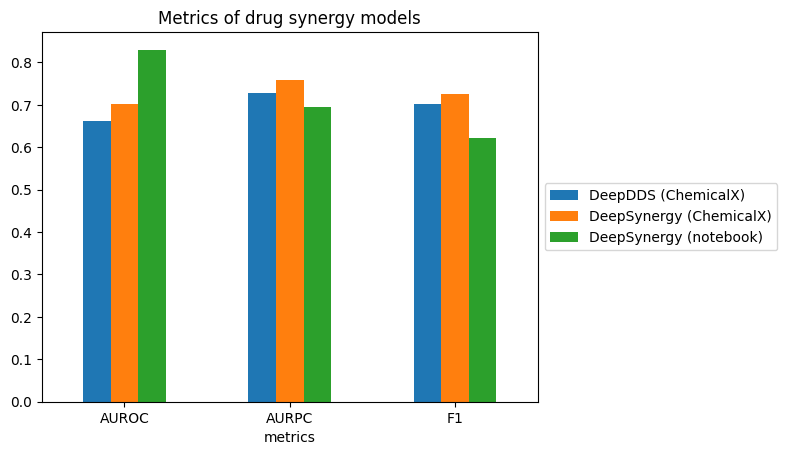

In [16]:
%matplotlib inline
df = pd.DataFrame({
    'models' : ['DeepSynergy (notebook)', 'DeepSynergy (notebook)', 'DeepSynergy (notebook)', 'DeepSynergy (ChemicalX)', 'DeepSynergy (ChemicalX)', 'DeepSynergy (ChemicalX)', 'DeepDDS (ChemicalX)', 'DeepDDS (ChemicalX)', 'DeepDDS (ChemicalX)'],
    'metrics' : ['AURPC', 'AUROC', 'F1', 'AURPC', 'AUROC', 'F1', 'AURPC', 'AUROC', 'F1'],
    'values' : [0.694, 0.830, 0.622, 0.758, 0.702, 0.725, 0.729, 0.663, 0.702]
    }).pivot(index='metrics', columns='models', values='values')

df.plot.bar(rot=0)
plt.title('Metrics of drug synergy models', color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

As seen above, the implementation of DeepSynergy in this report achieved a higher AUROC than the DeepSynergy and DeepDDS model implmentations by ChemicalX; however, it did not achieve a higher AURPC or F1 score than those two models.

One reason the model may not have performed as well as the original implementation is that not all of the optimizations in the ChemicalX library were implemented in this report, such as the training & evalution pipline, batch generators, and other various abstractions.

# Discussion

In this report, the DeepSynergy model implementation from ChemicalX was reproduced. Referencing existing code from the library's GitHub repository helped shape the flow of this report; however, the library included many more abstractions to accomdate the 10 other models implemented by ChemicalX. Some abstractions include a data structure for drug pairs, a parent class for all models, training data batch generators, etc. These abstractions were not included in this report since it was unecessary to implement one model.


# References
<!--
1.   Sun, J, [paper title], [journal title], [year], [volume]:[issue], doi: [doi link to paper] -->

1. Rozemberczki, B., Hoyt, C. T., Gogleva, A., Grabowski, P., Karis, K., Lamov, A., Nikolov, A., Nilsson, S., Ughetto, M., Wang, Y., Derr, T., & Gyori, B. M.,
ChemicalX: A Deep Learning Library for Drug Pair Scoring,
Proceedings of the 28th ACM SIGKDD Conference on Knowledge Discovery and Data Mining,
2022,
KDD ’22:The 28th ACM SIGKDD Conference on Knowledge Discovery and Data Mining, 3819–3828,
doi:https://doi.org/10.1145/3534678.3539023


2. Preuer, K., Lewis, R. P. I., Hochreiter, S., Bender, A., Bulusu, K. C., & Klambauer, G.,
DeepSynergy: predicting anti-cancer drug synergy with Deep Learning,
Bioinformatics,
2018,
34:9, 1538–1546,
doi:https://doi.org/10.1093/bioinformatics/btx806


3. J. Wang and X. Liu and S. Shen and L. Deng and H. Liu.,
DeepDDS: deep graph neural network with attention mechanism to predict synergistic drug combinations,
Briefings in Bioinformatics,
2021,
23:1
doi:https://doi.org/10.1093/bib/bbab390


4. Liu, H., Zhang, W., Zou, B., Wang, J., Deng, Y., & Deng, L.,
DrugCombDB: a comprehensive database of drug combinations toward the discovery of combinatorial therapy,
Nucleic Acids Research,
2020,
48:D1, D871-D881,
doi:https://doi.org/10.1093/nar/gkz1007